In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import ast
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import sys

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [2]:
#load the encoder, encode the reviews, and positive/negative review list
encoder=tfds.features.text.SubwordTextEncoder.load_from_file('SteamData/SteamReviewVocab')

    
generic = lambda x: ast.literal_eval(x)

starting_dataframe=pd.read_csv('SteamData/FormattedReviewRatingList.csv', )
starting_dataframe=starting_dataframe.rename(columns={'0': 'review'})

#shuffle the entire dataset
starting_dataframe = starting_dataframe.sample(frac = 1)


ratings_array=starting_dataframe.loc[:, 'Rating'].to_numpy()

test_ratio=0.1
test_size=round(test_ratio*len(ratings_array))

test_dataframe= starting_dataframe.iloc[0:test_size].copy()
train_dataframe = starting_dataframe.iloc[test_size:].copy()


DATASET_SIZE = len(ratings_array)


print("DATASET_SIZE: " + str(DATASET_SIZE))


DATASET_SIZE: 9193


In [3]:
train_dataframe['review'] = train_dataframe['review'].apply(ast.literal_eval)
test_dataframe['review'] = test_dataframe['review'].apply(ast.literal_eval)


train_dataframe['review'] = train_dataframe['review'].apply(tf.convert_to_tensor)
train_dataframe['Rating'] = train_dataframe['Rating'].apply(tf.convert_to_tensor)

test_dataframe['review'] = test_dataframe['review'].apply(tf.convert_to_tensor)
test_dataframe['Rating'] = test_dataframe['Rating'].apply(tf.convert_to_tensor)

In [6]:
REVIEW_LENGTH=test_dataframe['review'][0].shape[0]
print("REVIEW_LENGTH: " + str(REVIEW_LENGTH))

tensor_feature_array=train_dataframe['review'].values
tensor_label_array=train_dataframe['Rating'].values


tensors_feature_list = tensor_feature_array.tolist()
tensors_label_list = tensor_label_array.tolist()


test_tensor_feature_array=test_dataframe['review'].values
test_tensor_label_array=test_dataframe['Rating'].values

test_tensors_feature_list = test_tensor_feature_array.tolist()
test_tensors_label_list = test_tensor_label_array.tolist()

REVIEW_LENGTH: 1249


In [7]:
total_dataset=tf.data.Dataset.from_tensor_slices((tensors_feature_list,tensors_label_list))

test_dataset=tf.data.Dataset.from_tensor_slices((test_tensors_feature_list,test_tensors_label_list))


In [8]:
##Split the encoded words into training and test datasets, take size is the amount of data that goes into the training set
training_ratio=0.6
take_size= round(training_ratio*(DATASET_SIZE-test_size))
batch_size=300
vocab_size=encoder.vocab_size

test_data= test_dataset.batch(test_size)

#Organizing our training and test data
train_data = total_dataset.take(take_size).batch(batch_size)

validation_data = total_dataset.skip(take_size).batch(1000)




In [9]:
embedding_dim=25
learn_rate= 0.003
#determining layers of our neural network
model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=(REVIEW_LENGTH)),
    layers.Dropout(rate=0.1),
    layers.Bidirectional(tf.keras.layers.LSTM(25)),
    layers.Dropout(rate=0.1),
    layers.Dense(1, activation='sigmoid')
])

#batch_input_shape=(batch_size, n_timesteps, n_features)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1249, 30)          254100    
_________________________________________________________________
dropout (Dropout)            (None, 1249, 30)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                14640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 270,601
Trainable params: 270,601
Non-trainable params: 0
__________________________________________________

In [10]:
#set the optimizer and loss equation here, then compile and run the model.
opt = tf.keras.optimizers.Adam(
    learning_rate=learn_rate
)
loss_eqn=tf.keras.losses.BinaryCrossentropy(
    from_logits=False)

early_stopping= tf.keras.callbacks.EarlyStopping(patience =2)

model.compile(optimizer=opt,
              loss=loss_eqn,
              metrics=['accuracy'])

history = model.fit(
    train_data,
    callbacks=[early_stopping],
    epochs=15,
    validation_data=validation_data)

Train for 17 steps, validate for 4 steps
Epoch 1/15
17/17 [==============================] - 6s 333ms/step - loss: 0.6733 - accuracy: 0.5685 - val_loss: 0.6430 - val_accuracy: 0.5716
Epoch 2/15
17/17 [==============================] - 2s 111ms/step - loss: 0.5775 - accuracy: 0.7216 - val_loss: 0.5313 - val_accuracy: 0.7680
Epoch 3/15
17/17 [==============================] - 2s 114ms/step - loss: 0.4323 - accuracy: 0.8131 - val_loss: 0.4665 - val_accuracy: 0.7807
Epoch 4/15
17/17 [==============================] - 2s 112ms/step - loss: 0.2965 - accuracy: 0.8844 - val_loss: 0.4533 - val_accuracy: 0.8215
Epoch 5/15
17/17 [==============================] - 2s 114ms/step - loss: 0.1984 - accuracy: 0.9261 - val_loss: 0.4914 - val_accuracy: 0.8160
Epoch 6/15
17/17 [==============================] - 2s 112ms/step - loss: 0.1377 - accuracy: 0.9521 - val_loss: 0.7175 - val_accuracy: 0.7876
Epoch 7/15
17/17 [==============================] - 2s 112ms/step - loss: 0.1326 - accuracy: 0.9510 - val_l

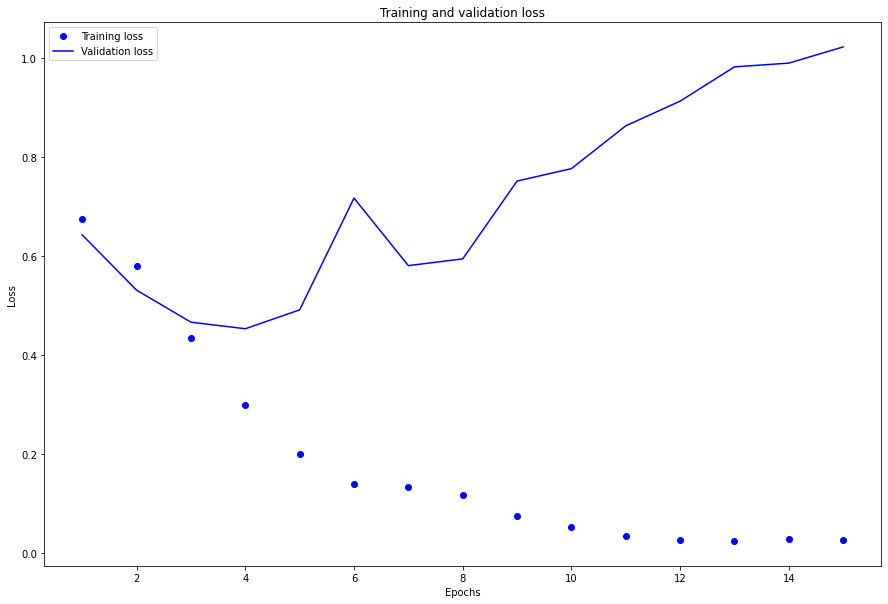

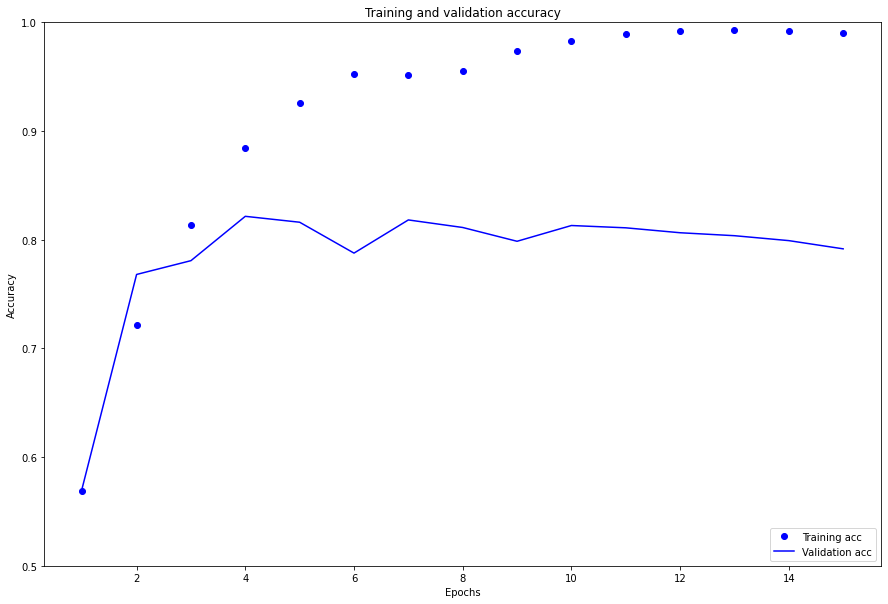

In [11]:
#plotting the accuracy and losses for our training and validation sets.
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [12]:
# Test the model on a unseen data sample
result = model.evaluate(test_data)

1/1 [==============================] - 0s 71ms/step - loss: 1.1279 - accuracy: 0.7856


In [13]:
#Extract TSV files of the word embeddings, to be used with the embedding project http://projector.tensorflow.org/
import io

e = model.layers[0]
weights = e.get_weights()[0]

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()